# Stationary Equilibrium

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Solve household problem](#toc2_)    
- 3. [Find stationary equilibrium](#toc3_)    
  - 3.1. [Direct approach](#toc3_1_)    
  - 3.2. [Indirect approach](#toc3_2_)    
  - 3.3. [Finding beta approach](#toc3_3_)    
  - 3.4. [Looking at the stationary equilibrium](#toc3_4_)    
    - 3.4.1. [Policy functions](#toc3_4_1_)    
    - 3.4.2. [Distributions](#toc3_4_2_)    
- 4. [Aggregate savings and the interest rate](#toc4_)    
- 5. [Idiosyncratic risk and the steady state interest rate](#toc5_)    
- 6. [Calibration](#toc6_)    
- 7. [Extra: Demand vs. supply of capital](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Contents:**

1. Introduces the `GEModelTools`
1. Solves and simulates a simple **Heterogenous Agent Neo-Classical (HANC) model**

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [ ]:
# compute the steady-state with the beta method
# Code HERE
print(model.par.beta_mean)

0.95


In [4]:
model.info(ss=True)

settings:
 par.py_hh = True
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: []
 unknowns: []
 targets: []

blocks (inputs -> outputs):
 production_firm: [] -> [Gamma=nan,K=nan,L=nan,rK=nan,w=nan,Y=nan]
 mutual_fund: [K=nan,rK=nan] -> [A=nan,r=nan]
 hh: [r=nan,w=nan] -> [A_hh=nan,C_hh=nan]
 market_clearing: [A=nan,A_hh=nan,L=nan,Y=nan,C_hh=nan,K=nan] -> [L_hh=nan,I=nan,clearing_A=nan,clearing_L=nan,clearing_Y=nan]


**MPC:**

In [5]:
def calc_MPC(par,ss):
    
    MPC = np.zeros(ss.D.shape)
    dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
    dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
    MPC[:,:,:-1] = dc/dm
    MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
    
    return MPC

MPC = calc_MPC(model.par,model.ss)

mean_MPC = np.sum(MPC*model.ss.D)
print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: nan


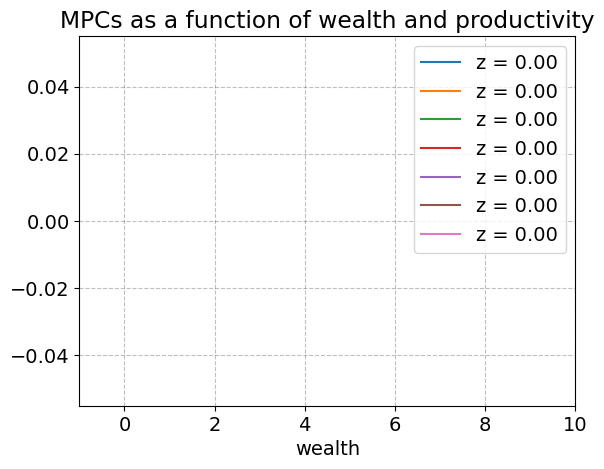

In [6]:
plt.plot(model.par.a_grid, MPC[0].T)
plt.xlim(-1, 10)
plt.legend([f'z = {z:.2f}' for z in model.par.z_grid])
plt.title('MPCs as a function of wealth and productivity')
plt.xlabel('wealth')
plt.show()

In [7]:
def calib_obj(beta_delta,model):
    """ calibration objective """
    
    #fill things up here: update beta_delta and compute ss 
    #model.find_ss(method = 'beta', beta_min = 0.5, beta_max = 0.98, do_print=False)
    
    return mean_MPC-0.27

In [8]:
from root_finding import brentq
model_calib = model.copy()
brentq(calib_obj,0.01,0.1,args=(model_calib,),do_print=True,varname='beta_delta',funcname='MPC-0.27',xtol=1e-8,rtol=1e-8);

UnboundLocalError: cannot access local variable 'fblk' where it is not associated with a value

In [ ]:
print(f'ss.r = {model_calib.ss.r*100:.2f} %')
print(f'ss.K = {model_calib.ss.K:.2f}')
print(f'K/Y = {(model_calib.ss.K / model_calib.ss.Y):.2f}')

ss.r = 1.25 %
ss.K = 16.00
K/Y = 16.00


Now, compute the distribution of wealth and compare it to the data, as in the previous notebook. How did the distribution of wealth change?

In [ ]:
# Code here